# Library

In [9]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# Data load

In [2]:
# LSH
all_df = pd.read_csv('df_all_best.csv')
all_df = all_df.sort_values(by='diff',ascending=False)

df_d1d5 = pd.read_csv('df_d1d5_best.csv')
df_d1d5 = df_d1d5.sort_values(by='diff',ascending=False)

df_d6d10 = pd.read_csv('df_d6d10_best.csv')
df_d6d10 = df_d6d10.sort_values(by='diff',ascending=False)

# Method 1 : 일관성, 방향성
$$
FI^{our} = Relu(FI^{inverse}) * sign(FI^{0->1})
$$

$$
일관성 : Relu(FI^{inverse})
$$

$$
방향성 : sign(FI^{0->1})
$$

## 일관성

In [3]:
# relu 방법 1
def relu(x):
    return np.maximum(0, x)

일관성_df = all_df[['feature','diff']]
일관성_df['diff'] = 일관성_df['diff'].apply(relu)

# # relu 방법 2
일관성_df = all_df[['feature','diff']]
일관성_df.loc[(일관성_df['diff'] <= 0),'diff'] = 0
일관성_df = 일관성_df.sort_values(by='feature')
일관성_df.index = list(range(4068))
일관성_df

<ipython-input-3-181eae80786d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  일관성_df['diff'] = 일관성_df['diff'].apply(relu)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,feature,diff
0,0,0.000000
1,50803,0.002118
2,50804,0.003495
3,50805,0.001575
4,50806,0.005405
...,...,...
4063,78112001103,0.002014
4064,79511050204,0.000000
4065,87701071218,0.013409
4066,87701083336,0.000000


## 방향성

In [27]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [28]:
# 3)
# FEATURES
a = pd.read_csv('total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

# No Change에 대한 평균예측값 (baseline)
preds = lstm2.predict(X_test)
pred_base = np.mean(preds)

# COMPUTE BASELINE
results = []
results.append({'feature':'BASELINE','pred_base':pred_base}) 

for k in tqdm(range(len(features))):

    # REVERSE ALL FEATURE K
    save_col = X_test[:,:,k].copy()
    X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])

    # COMPUTE BCE WITH FEATURE K REVERSED
    pred2 = lstm2.predict(X_test)
    pred2_mean = np.mean(pred2)
    
    results.append({'feature':features[k],'pred2':pred2_mean})
    X_test[:,:,k] = save_col

100%|██████████| 4068/4068 [39:59<00:00,  1.70it/s]


In [77]:
# 4) diff 구해서 sign함수에 적용

방향성_df = pd.DataFrame(results)
pred_base = 방향성_df.iloc[0,1]
방향성_df = 방향성_df.drop(index=0, columns=['pred_base'])
방향성_df['diff'] = 방향성_df['pred2']-pred_base

방향성_df.loc[(방향성_df['diff']>0),'diff'] = 1
방향성_df.loc[(방향성_df['diff']<=0),'diff'] = -1
방향성_df = 방향성_df.sort_values(ascending=True, by='feature')
# 방향성_df.to_csv('m1_방향성df.csv',index=False)

## 일관성 * 방향성

In [4]:
방향성_df = pd.read_csv('m1_방향성df.csv')
방향성_df.index = list(range(4068))

method1 = 일관성_df.copy()
method1['mul'] = 일관성_df['diff'] * 방향성_df['diff']

method1 = method1.sort_values(ascending=False, by='mul')
method1

,feature,diff,mul
2195,409606211,0.059180,0.059180
1276,74606211,0.036668,0.036668
1081,67434504,0.032467,0.032467
982,54817525,0.029130,0.029130
2744,10019055302,0.027498,0.027498
...,...,...,...
162,51200,0.016966,-0.016966
1815,182138167,0.017109,-0.017109
37,50889,0.018246,-0.018246
469,4003822,0.019987,-0.019987


In [24]:
# method1.to_csv('method1_df.csv',index=False)

# Entropy 추가
- 일관성(Relu), 방향성(sign)을 곱한 값이 있는 df -> method1_df.csv

In [39]:
x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = H(np.array([rate_1, rate_0]))
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)

100%|██████████| 4068/4068 [00:00<00:00, 9293.92it/s]


In [51]:
m1 = pd.read_csv('method1_df.csv')
m1_entropy = pd.merge(m1, entropy_df, on='feature')
m1_entropy['final_mul'] = m1_entropy['mul'] * m1_entropy['entropy']
m1_entropy = m1_entropy.sort_values(by='final_mul', ascending=False)
m1_entropy

m1_entropy.to_csv('m1_entropy.csv',index=False)

,feature,diff,mul,entropy,final_mul
24,409176230,0.014189,0.014189,0.380630,0.005401
21,51003,0.014328,0.014328,0.329998,0.004728
111,487980125,0.007584,0.007584,0.609046,0.004619
105,50862,0.007828,0.007828,0.470553,0.003684
44,50813,0.011908,0.011908,0.302050,0.003597
...,...,...,...,...,...
4053,56017275,0.011329,-0.011329,0.188707,-0.002138
4067,227194,0.025418,-0.025418,0.084824,-0.002156
4016,224277,0.006929,-0.006929,0.315556,-0.002187
4034,50861,0.008277,-0.008277,0.400005,-0.003311


# 그래프 

In [21]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(PPL_list,top_or_down):
    # 1) PRE_top10의 index 구하기
    PPL_top10 = top_or_down
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(PPL_top10): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

In [11]:
method1 = pd.read_csv('m1_entropy.csv')
method1 = method1.sort_values(by='final_mul',ascending=False)
m1_feature = method1['feature'].tolist()

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []
for i in m1_feature:
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## 전체

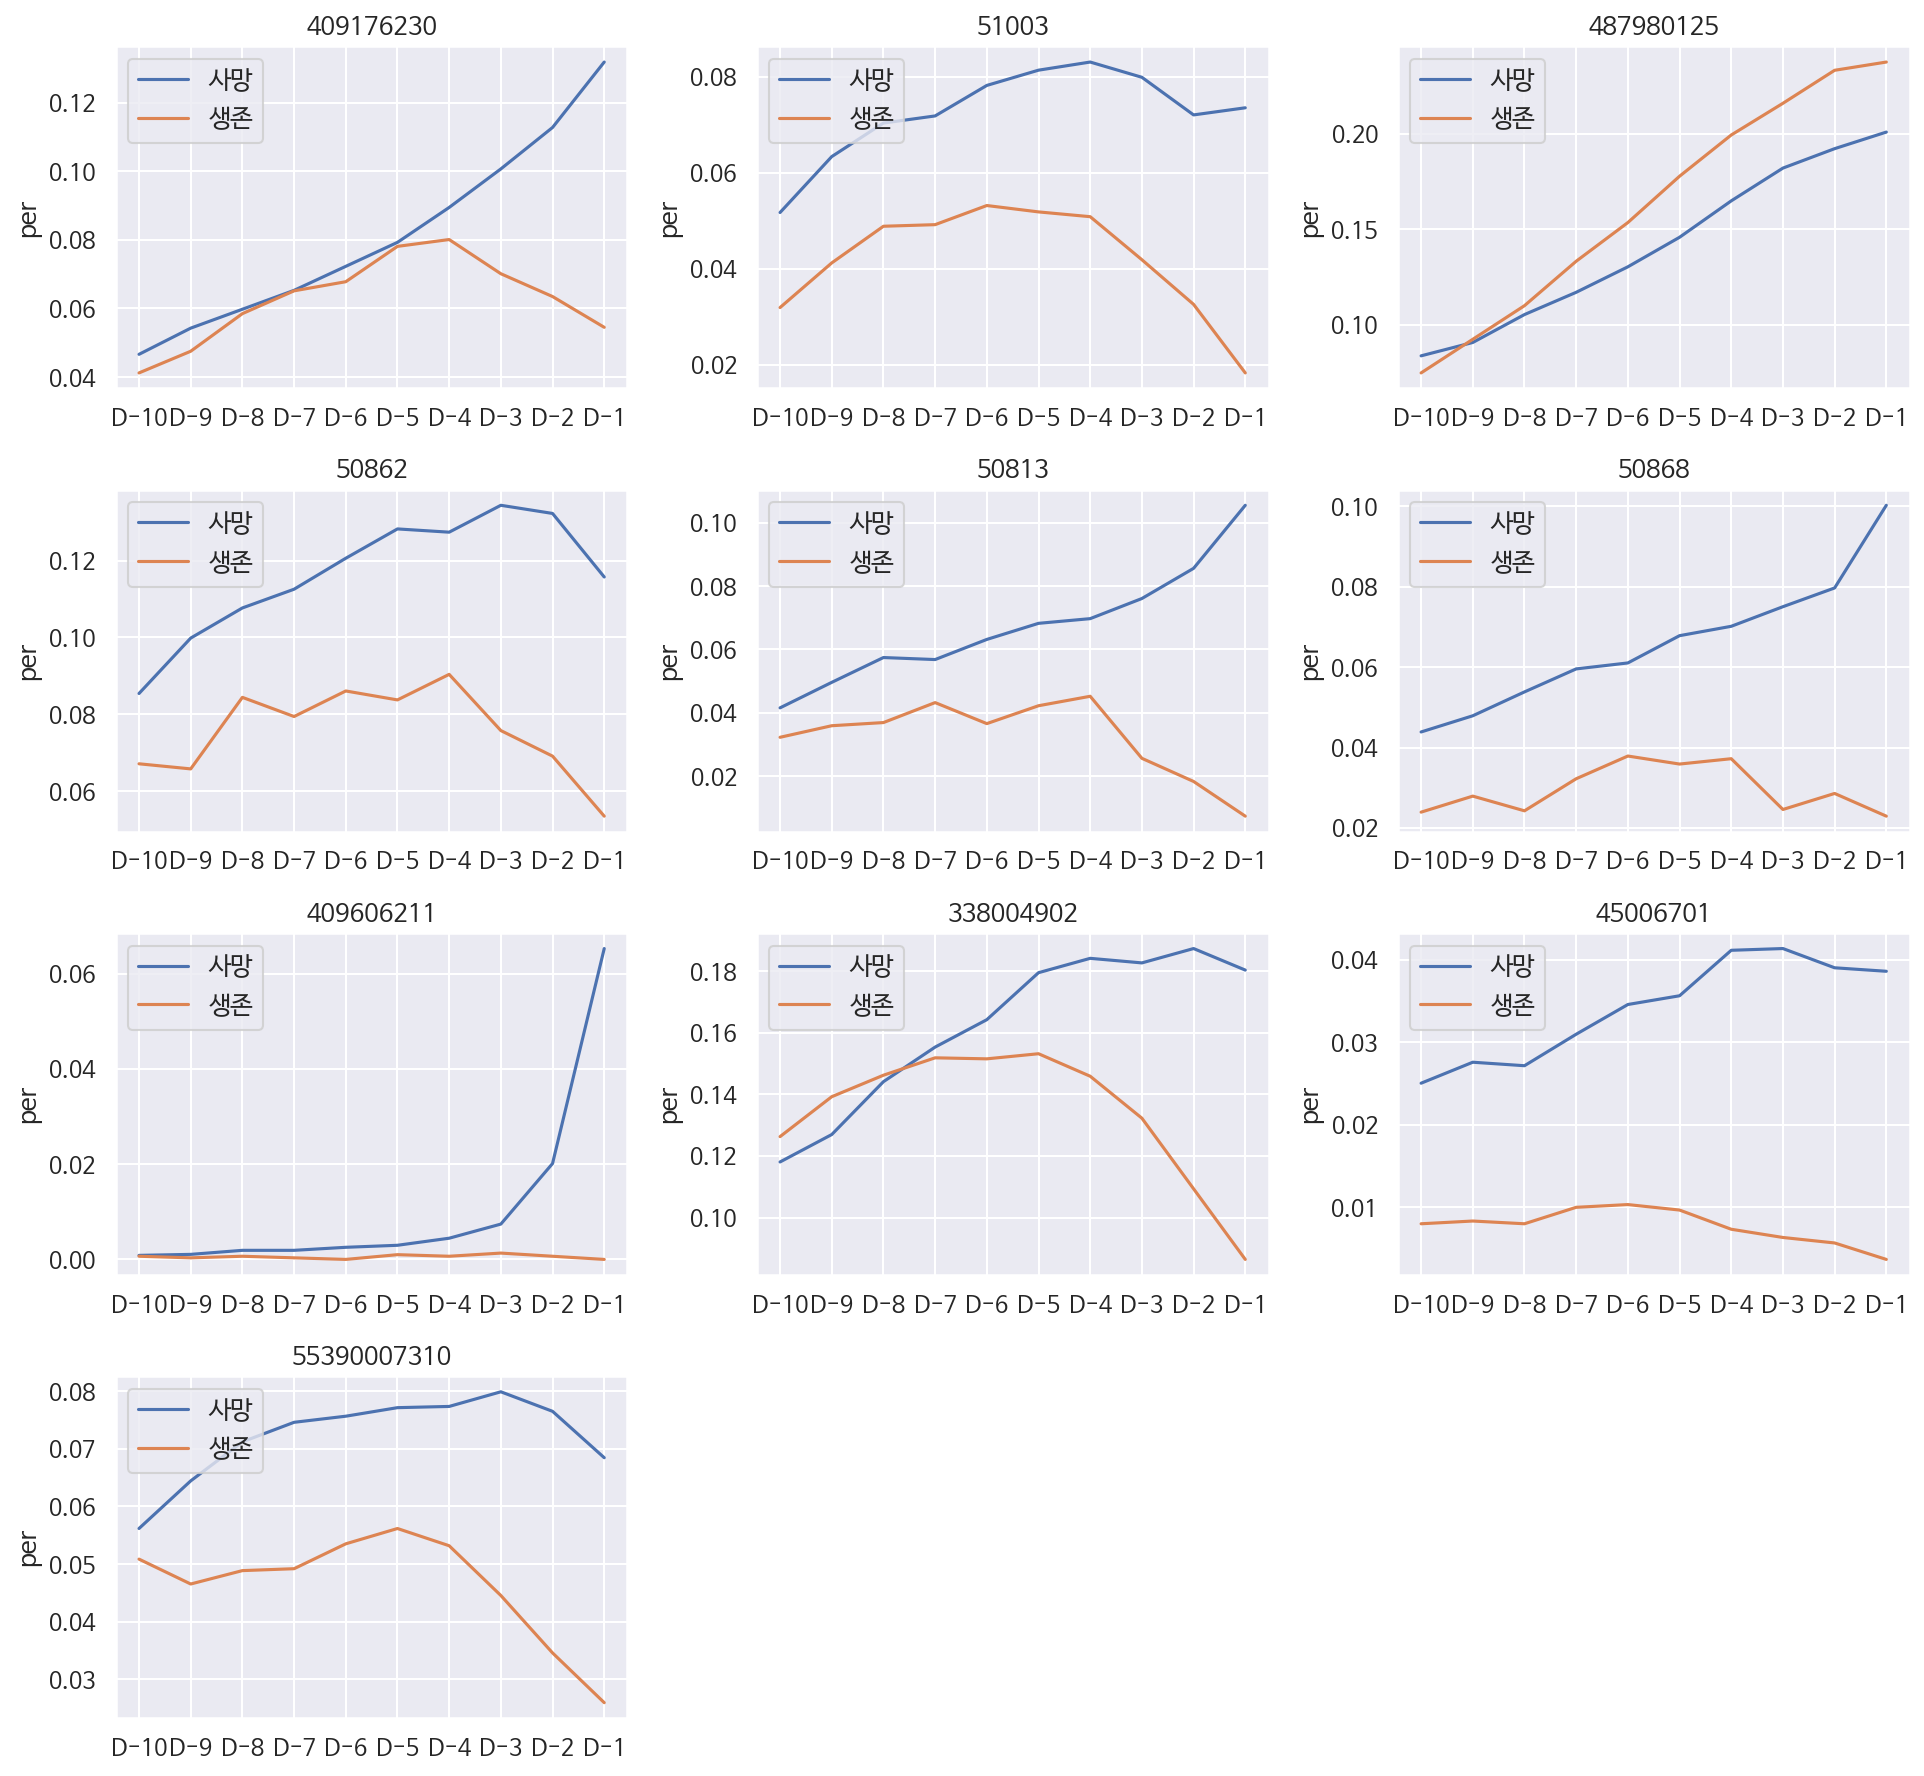

In [12]:
# 상위 10개 - 일관성 높은 사망 관련 feature
absum(m1_feature,m1_feature[:10])

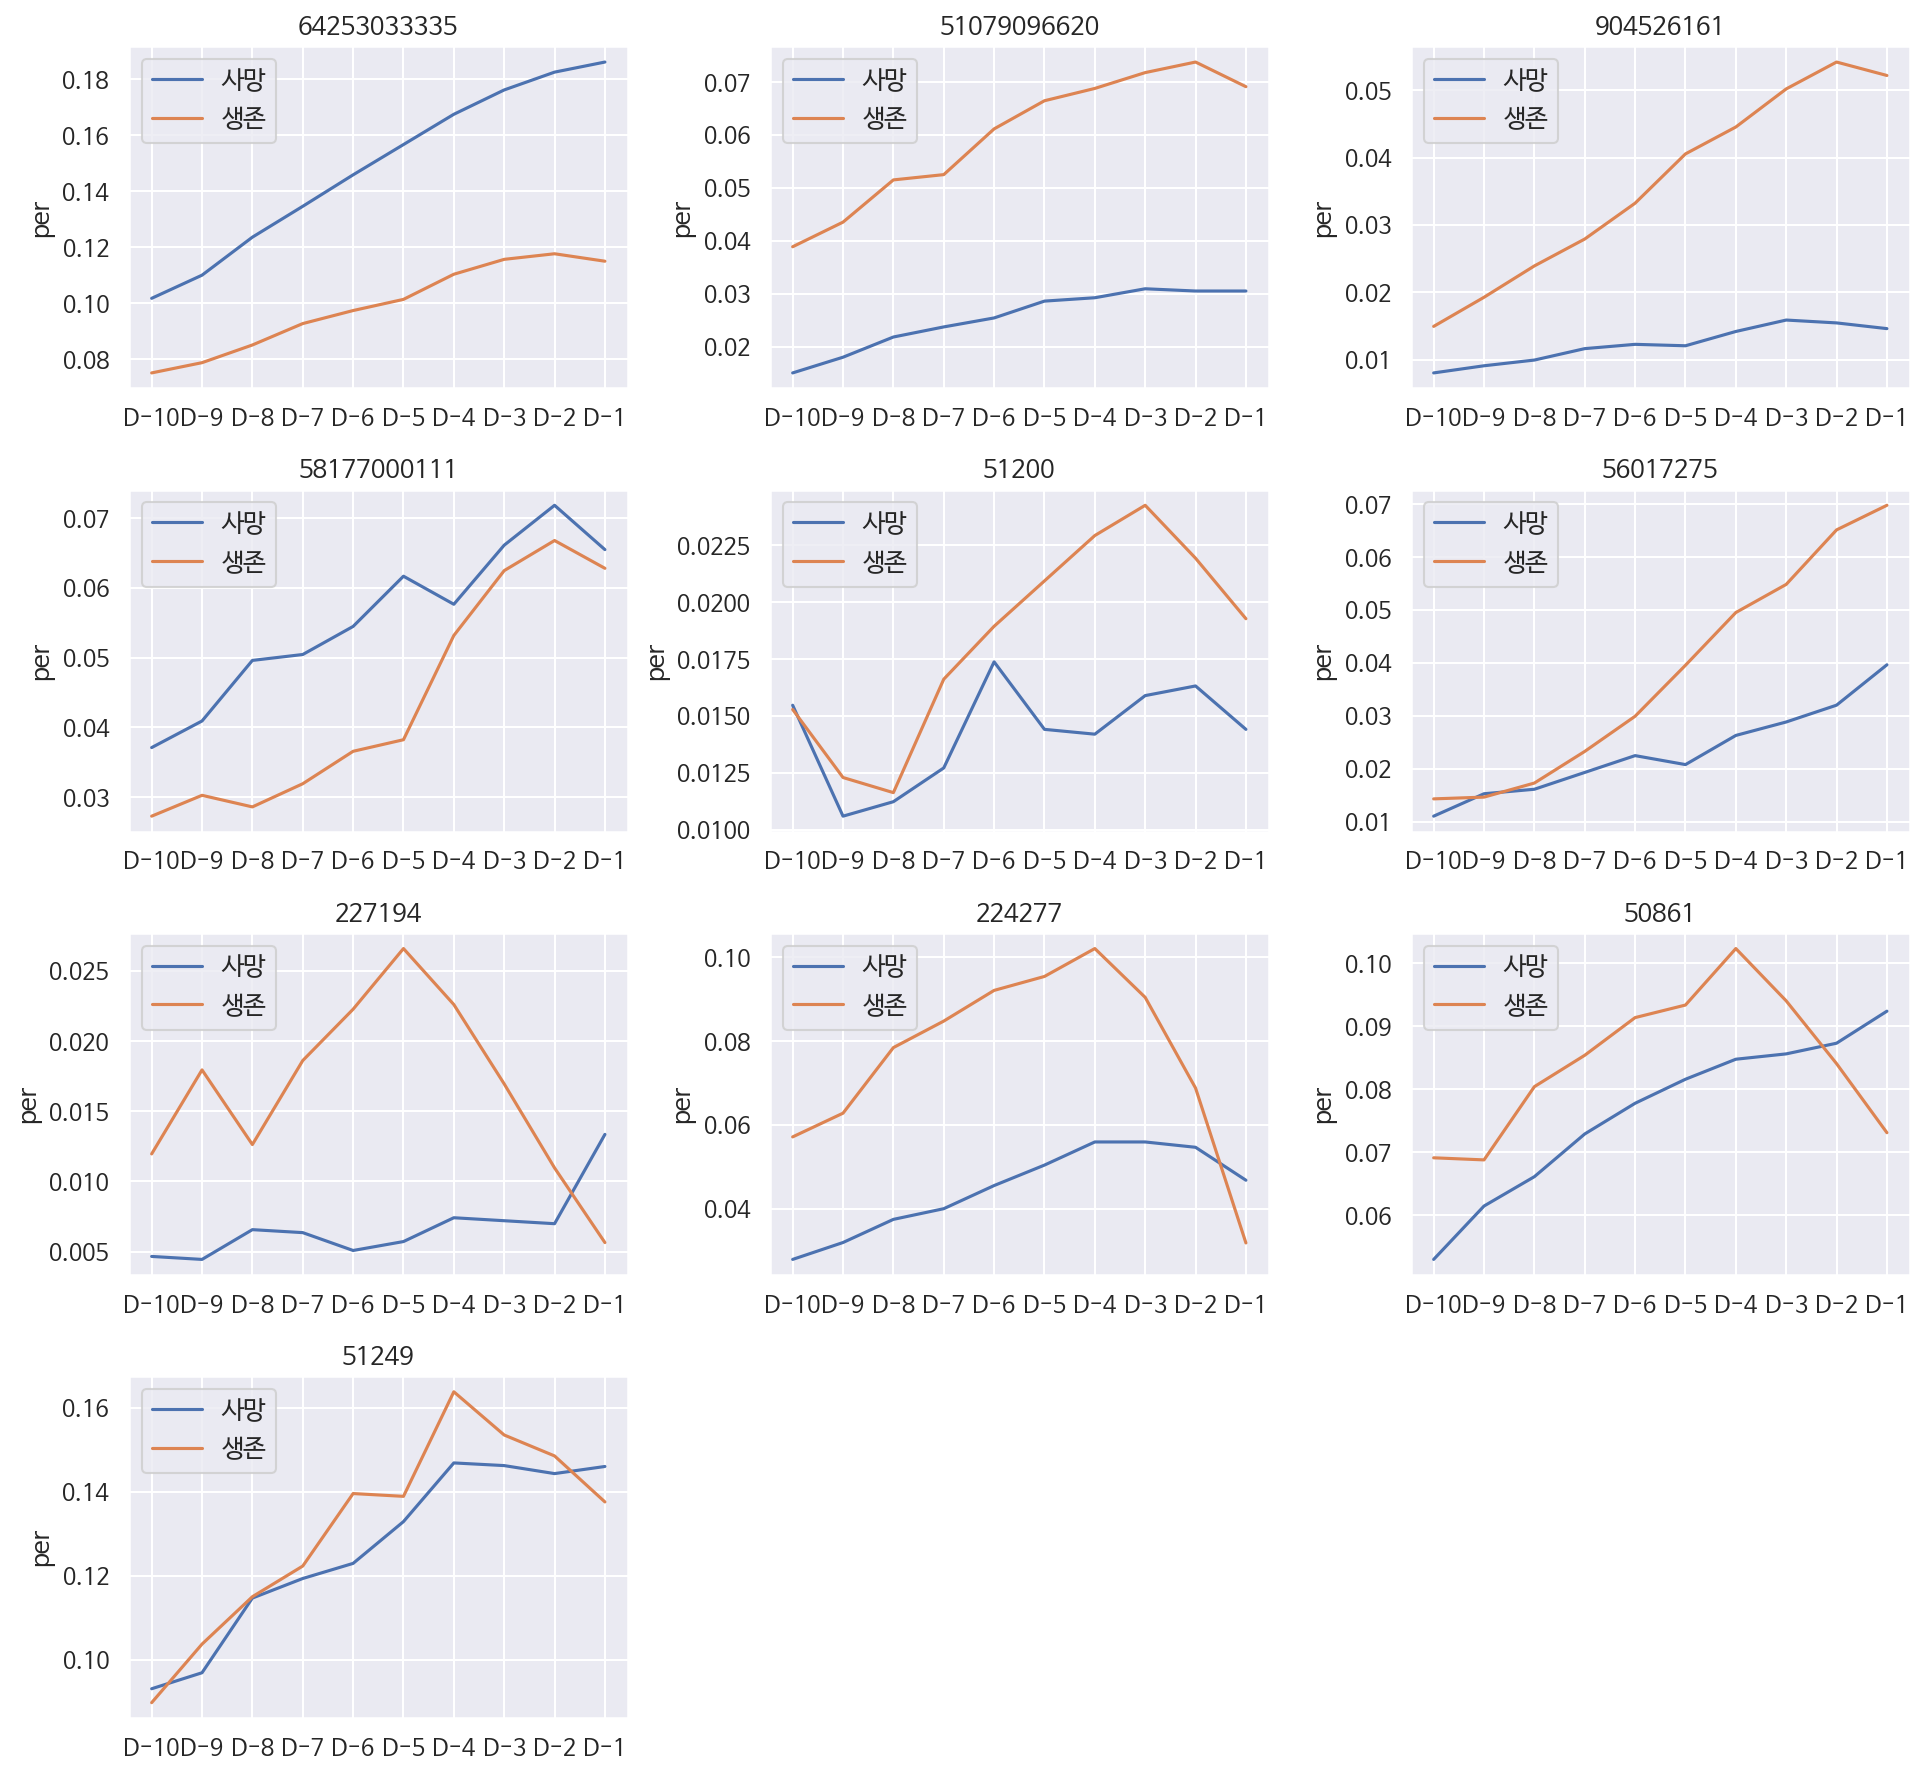

In [13]:
# 하위 10개 - 일관성 높은 생존 관련 feature
absum(m1_feature,m1_feature[-10:])

## PRE

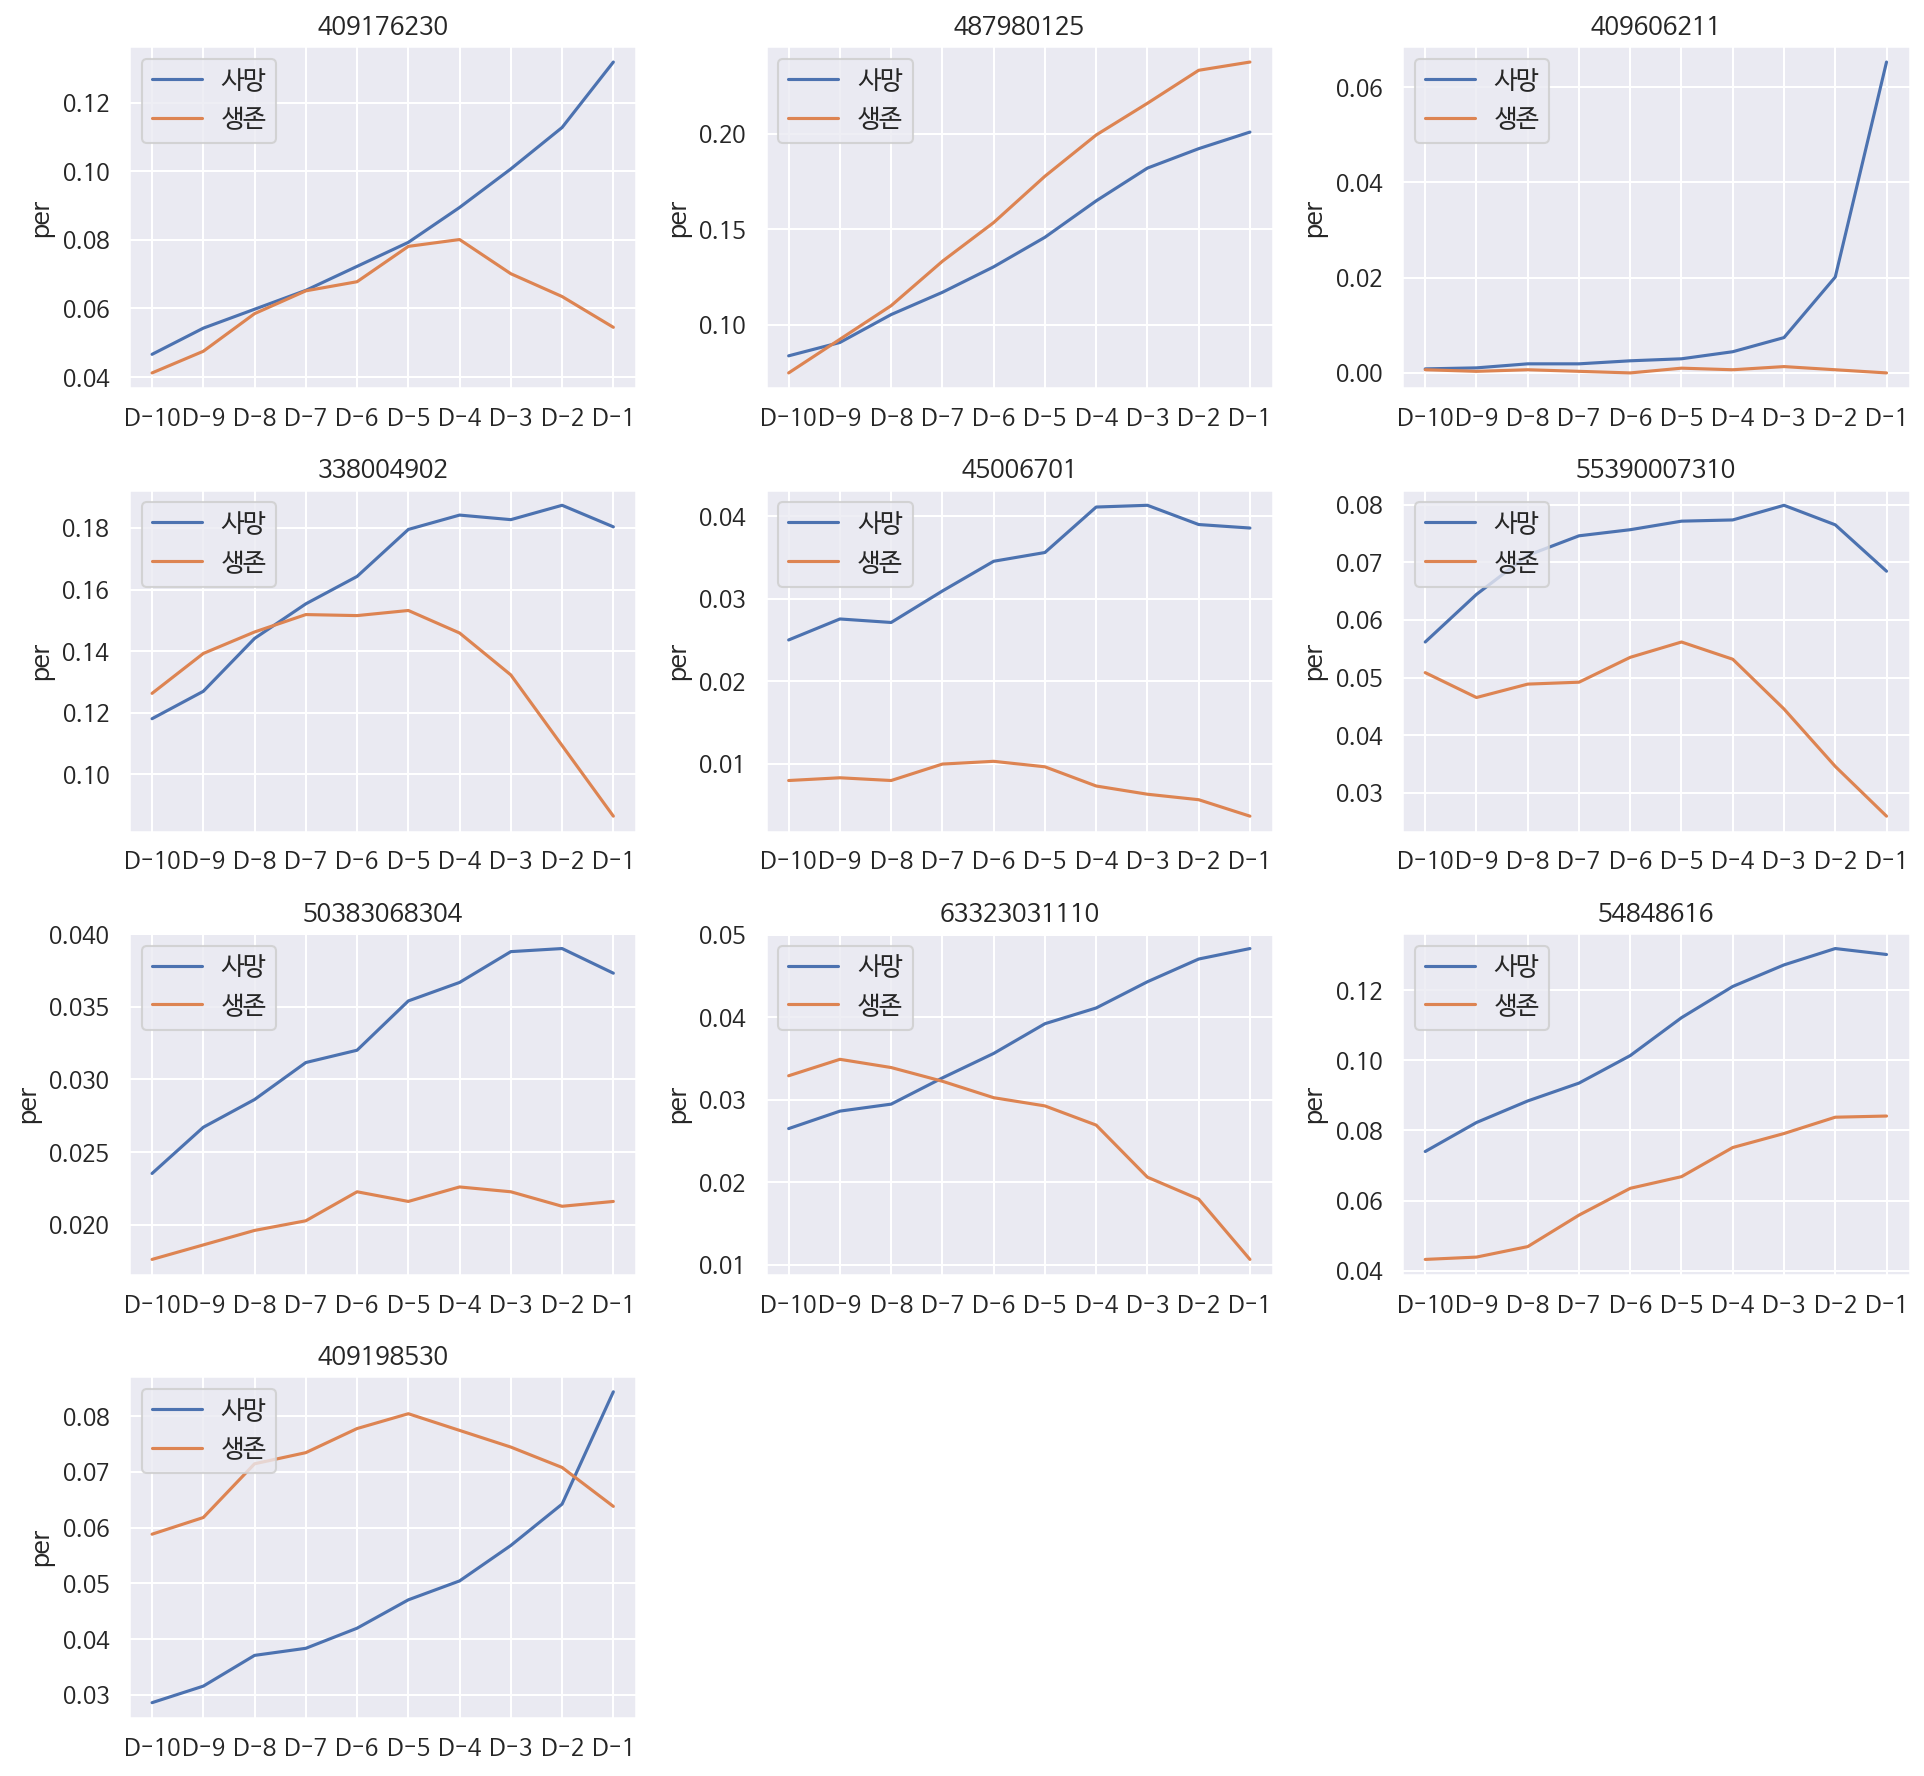

In [54]:
# 상위 10개 - 일관성 높은 사망 관련 feature
absum(PRE_list,PRE_list[:10])

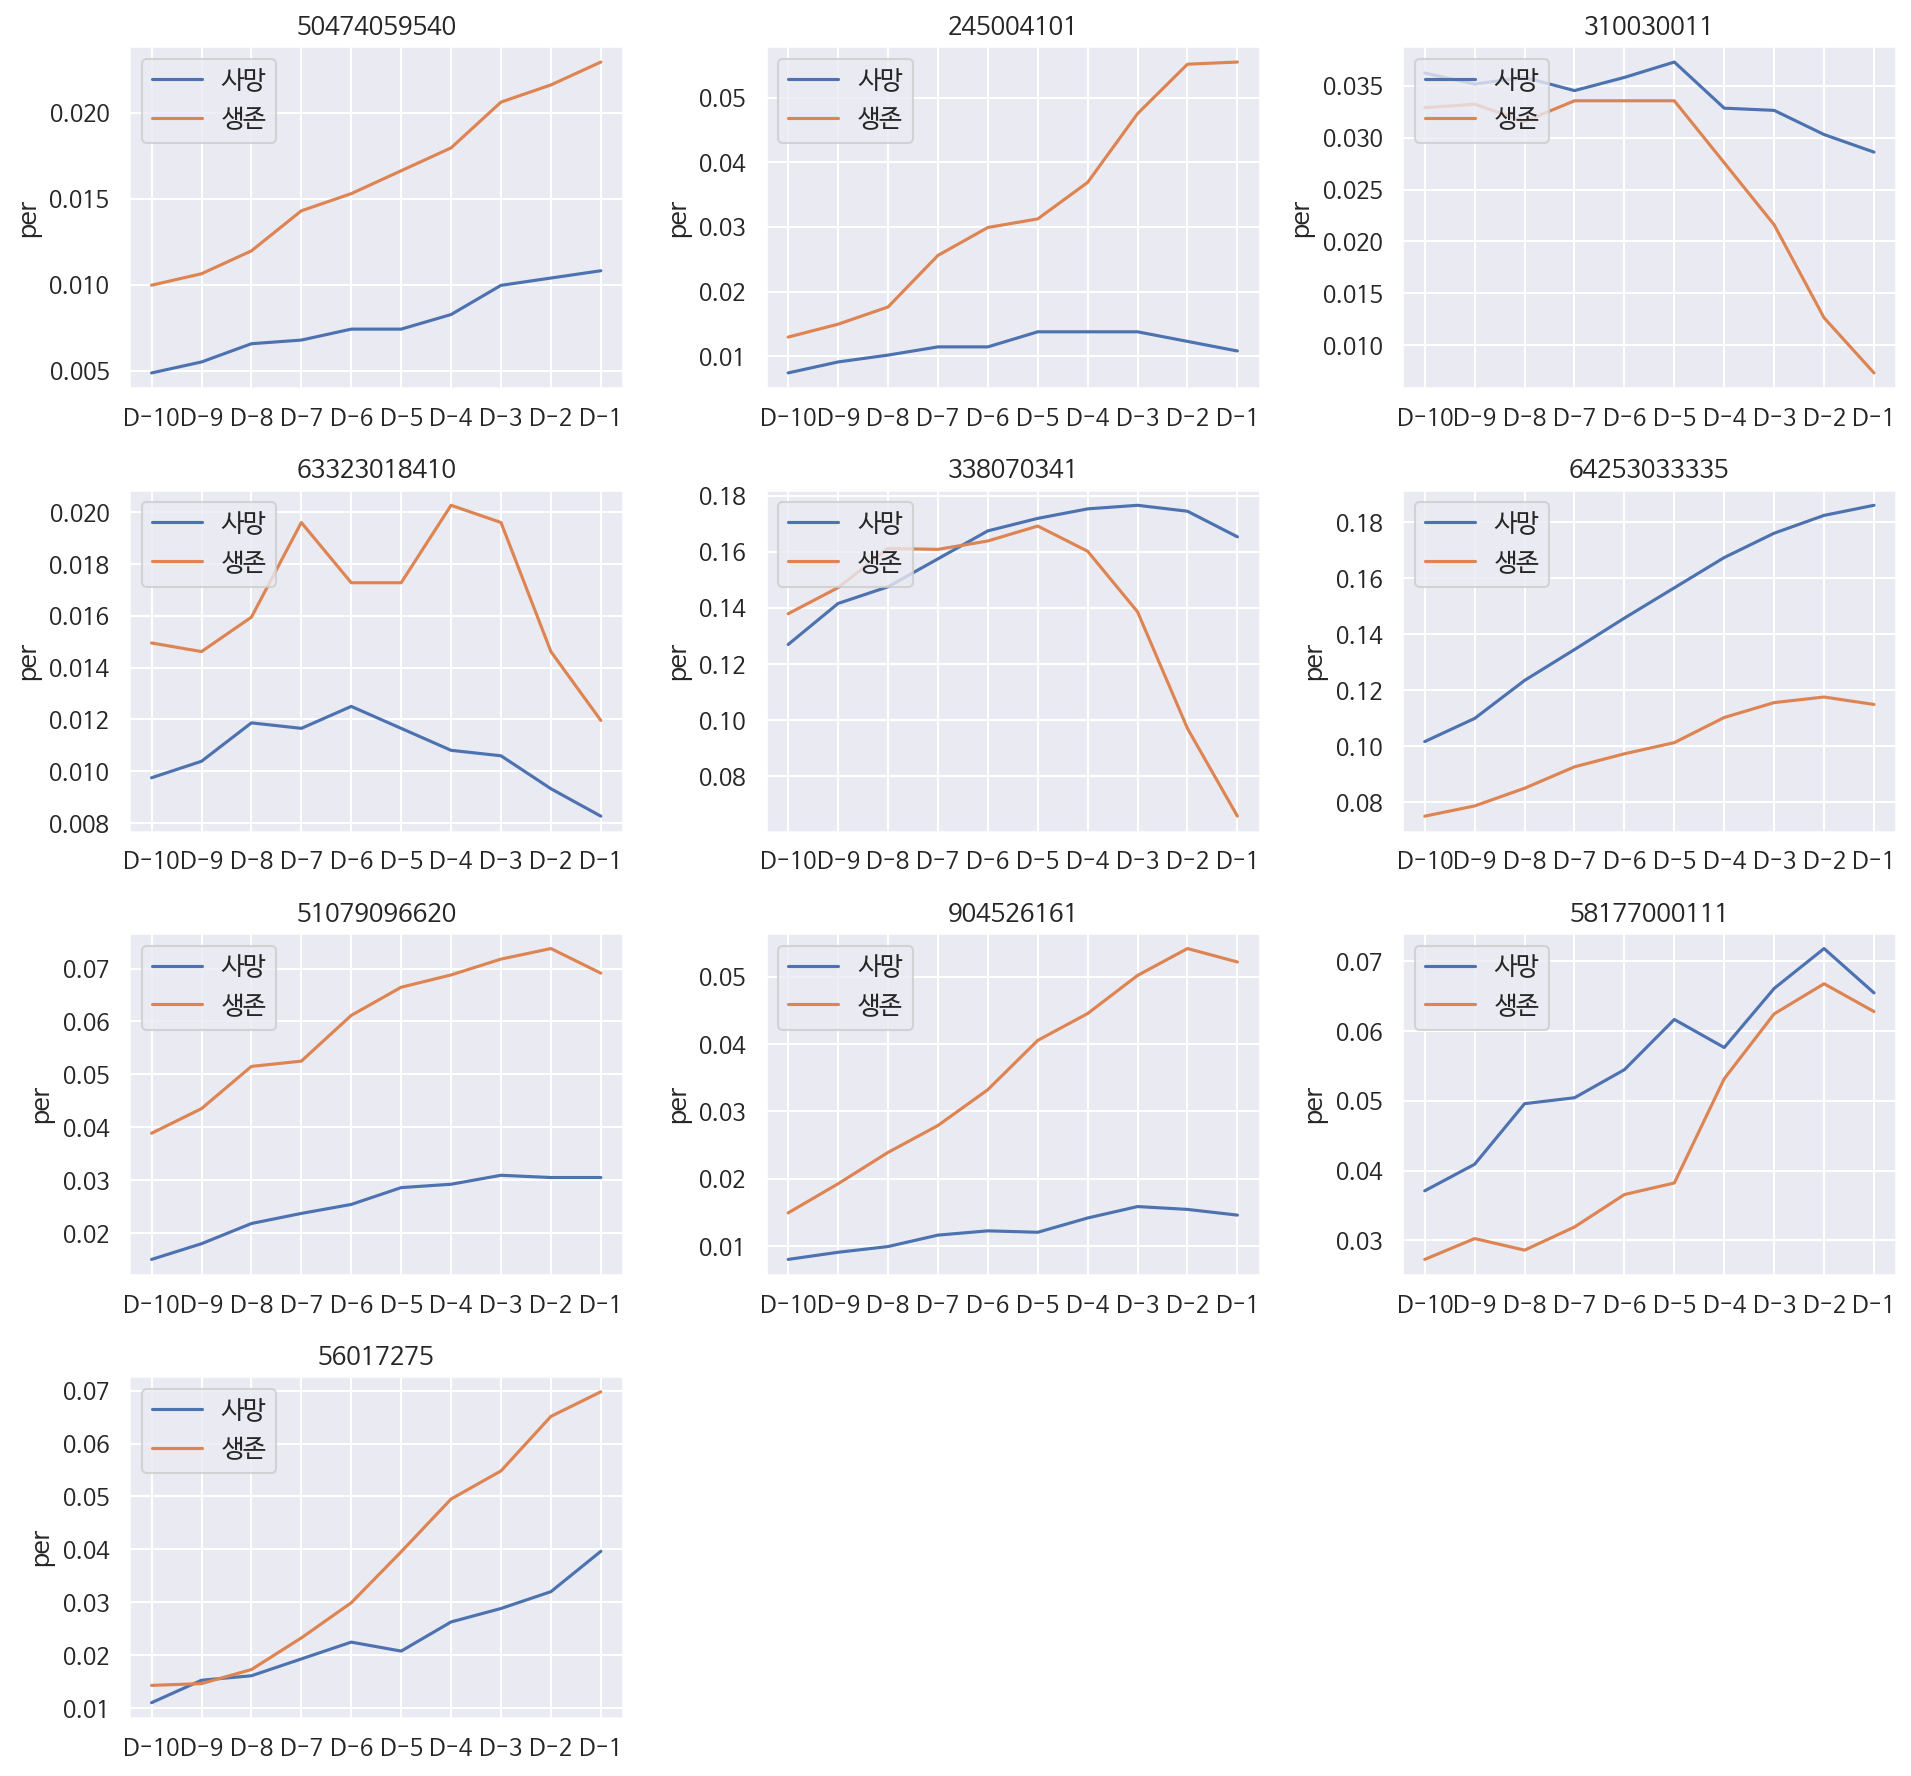

In [55]:
# 하위 10개 - 일관성 높은 생존 관련 feature
absum(PRE_list,PRE_list[-10:])

## PRO

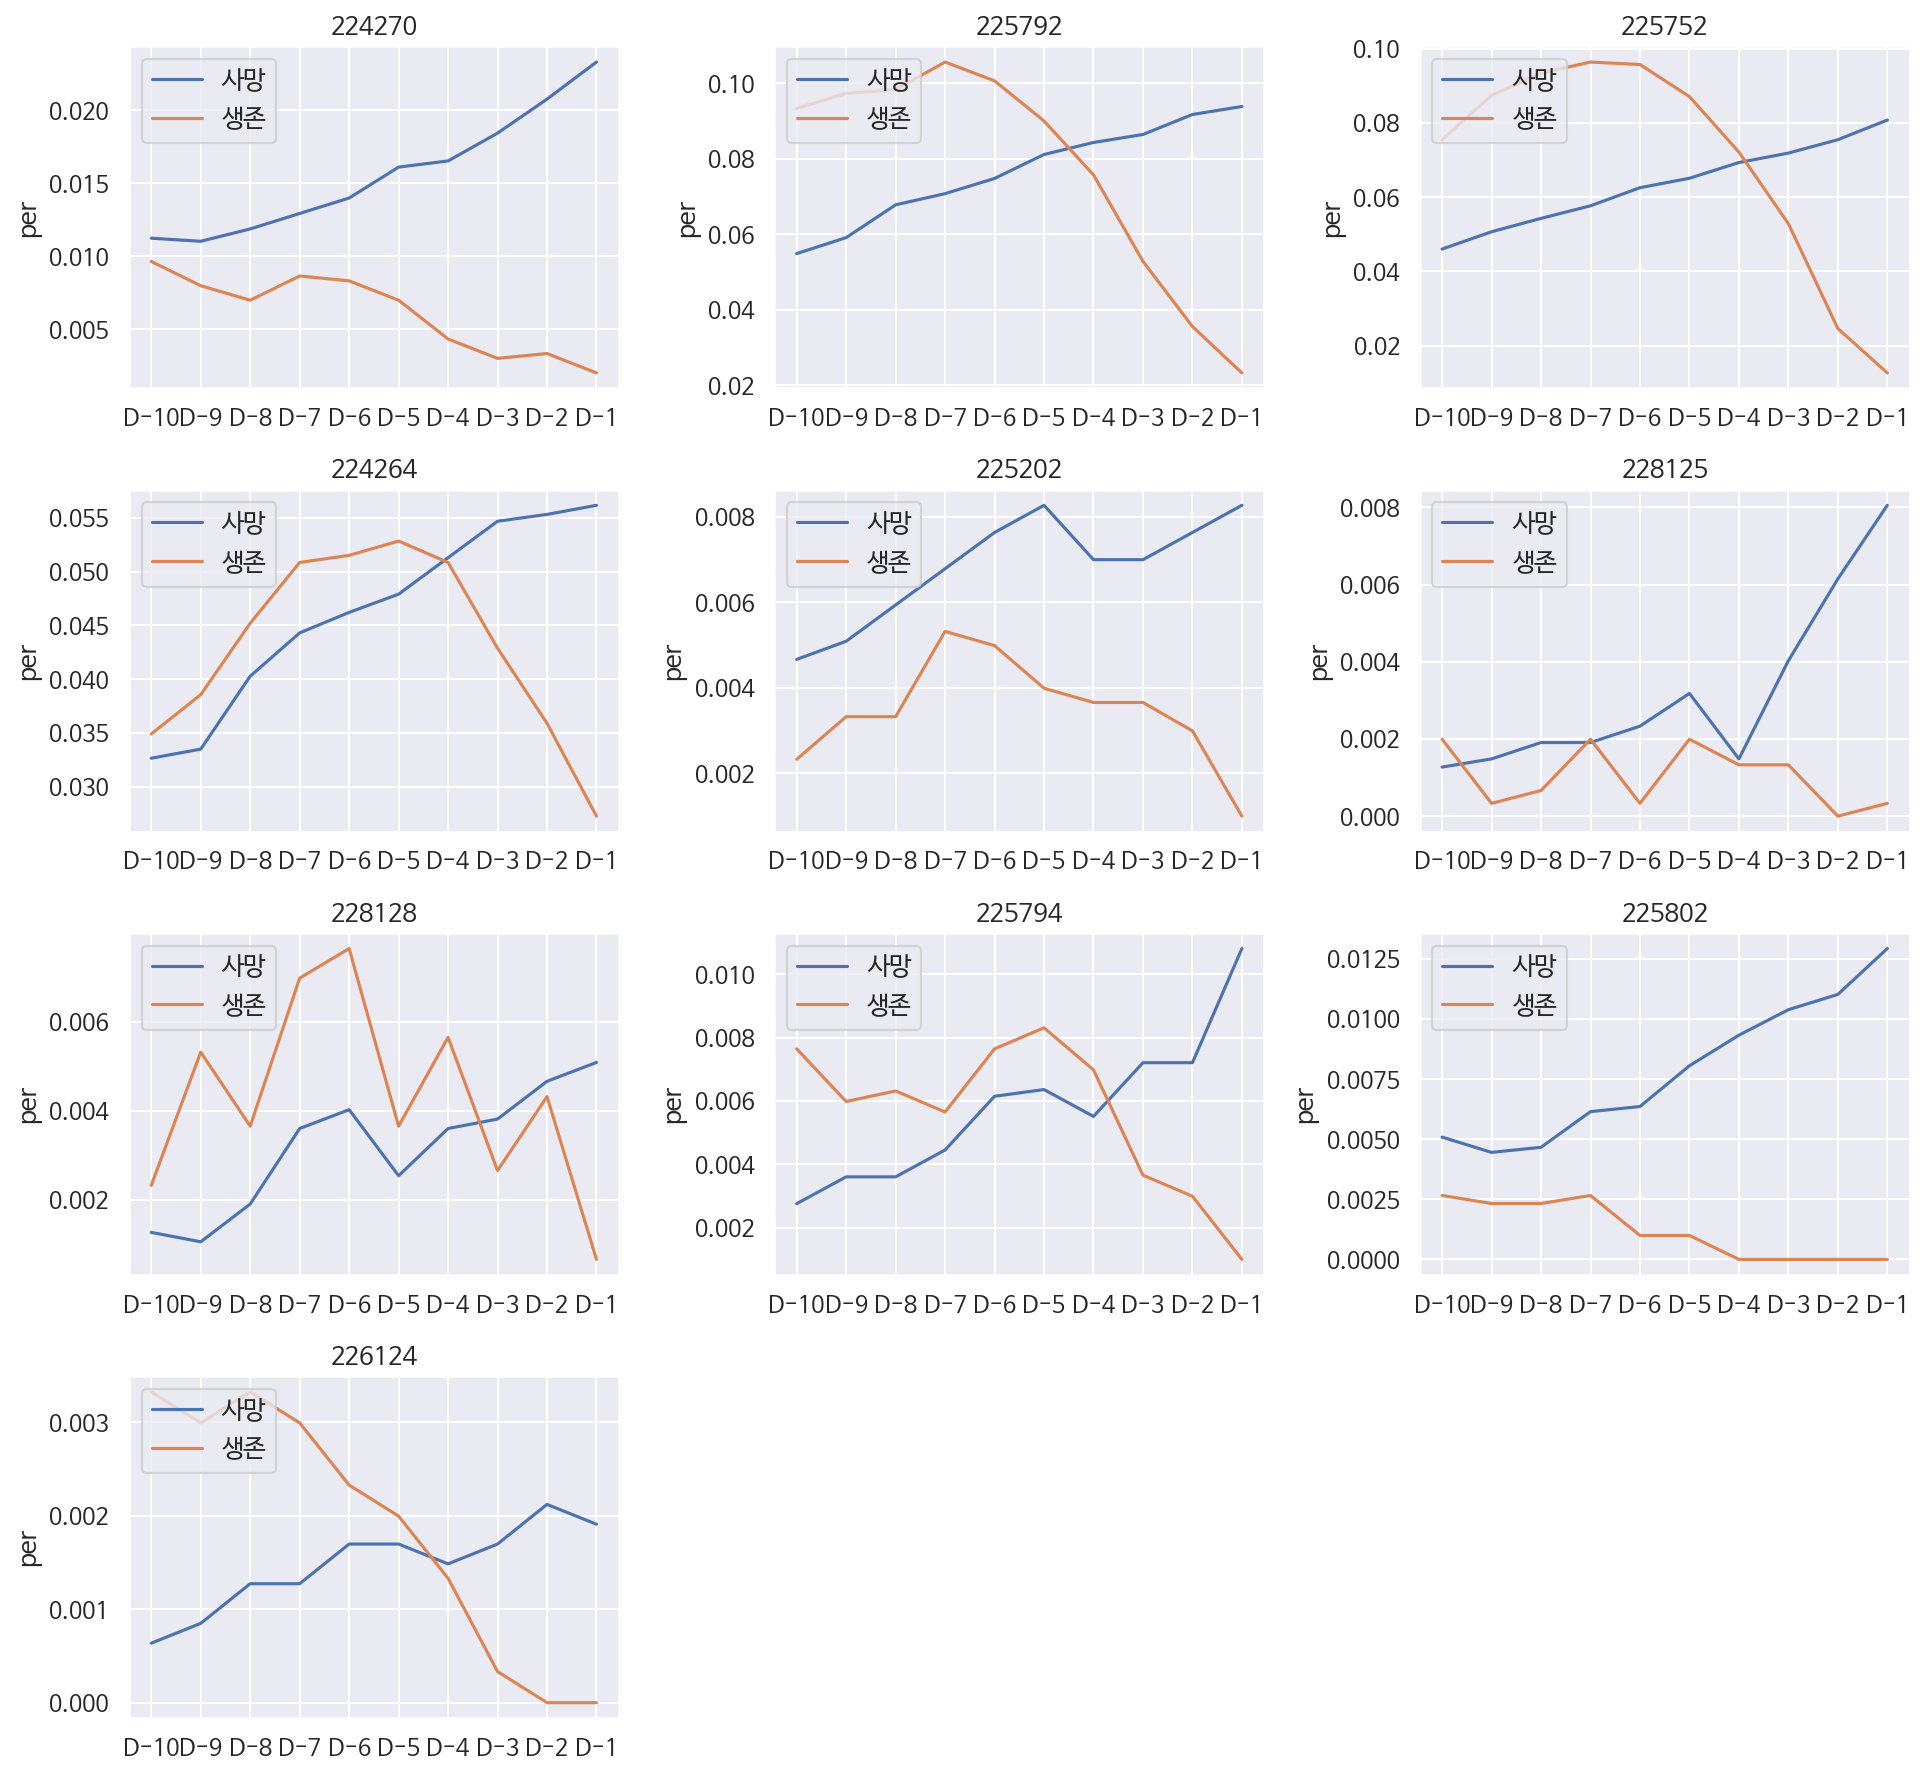

In [56]:
# 상위 10개 - 일관성 높은 사망 관련 feature
absum(PRO_list,PRO_list[:10])

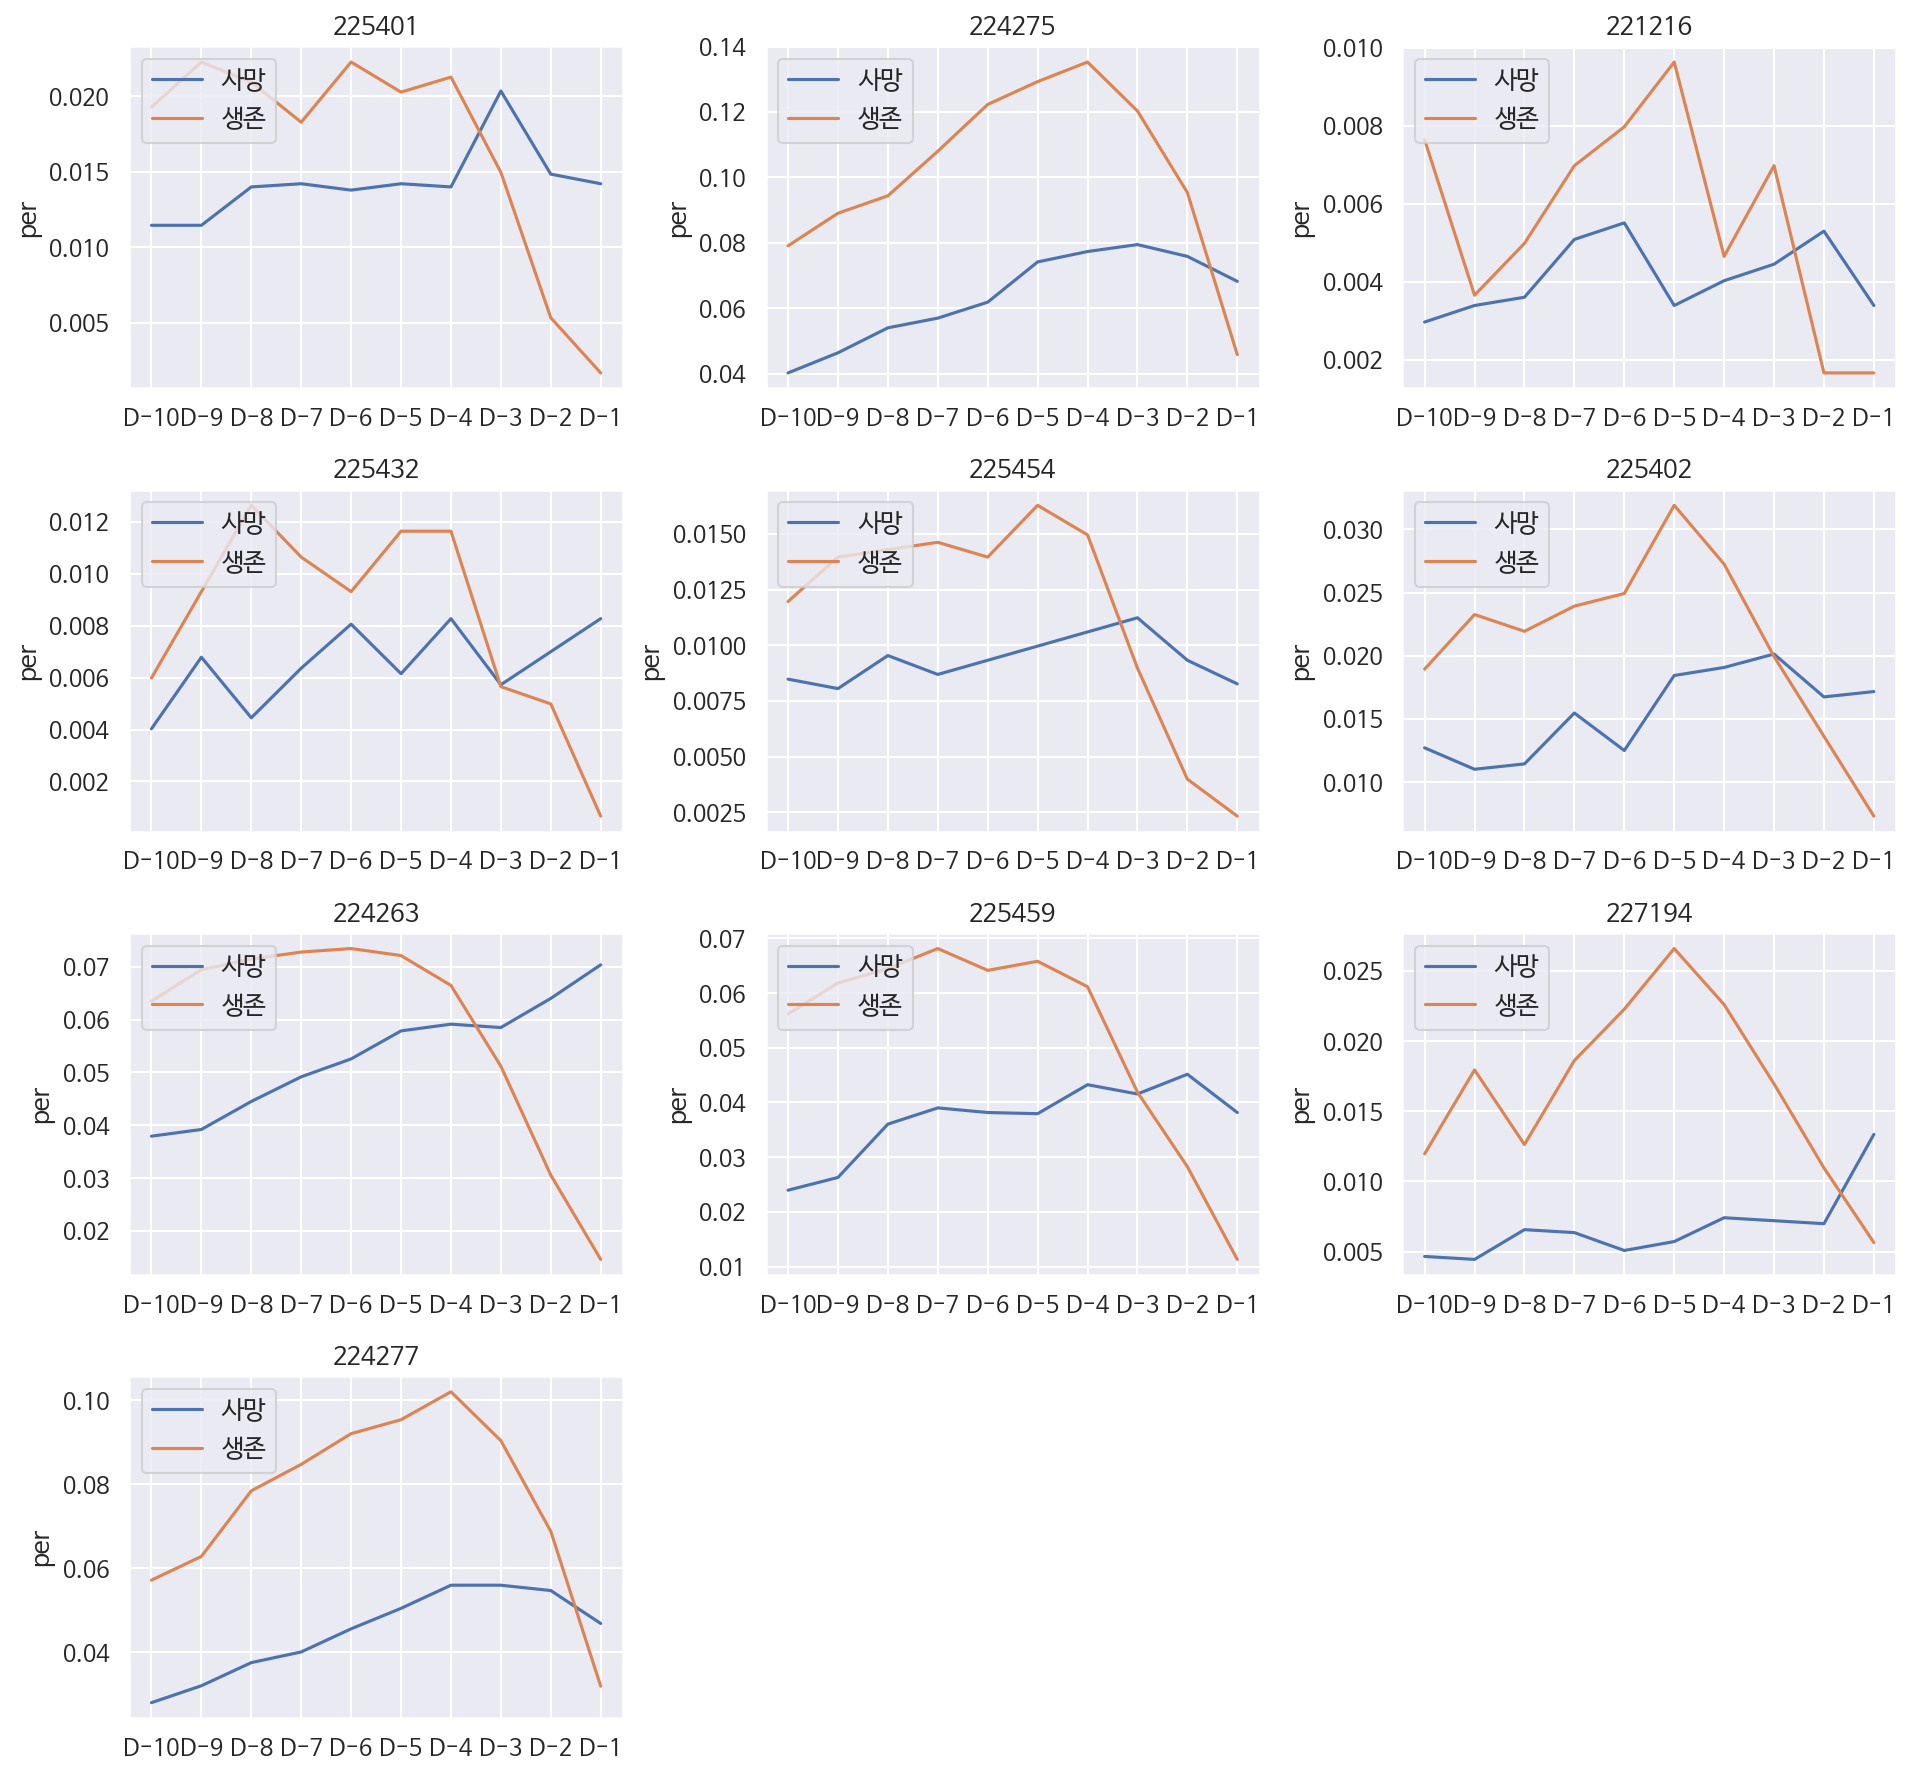

In [57]:
# 하위 10개 - 일관성 높은 생존 관련 feature
absum(PRO_list,PRO_list[-10:])

## LAB

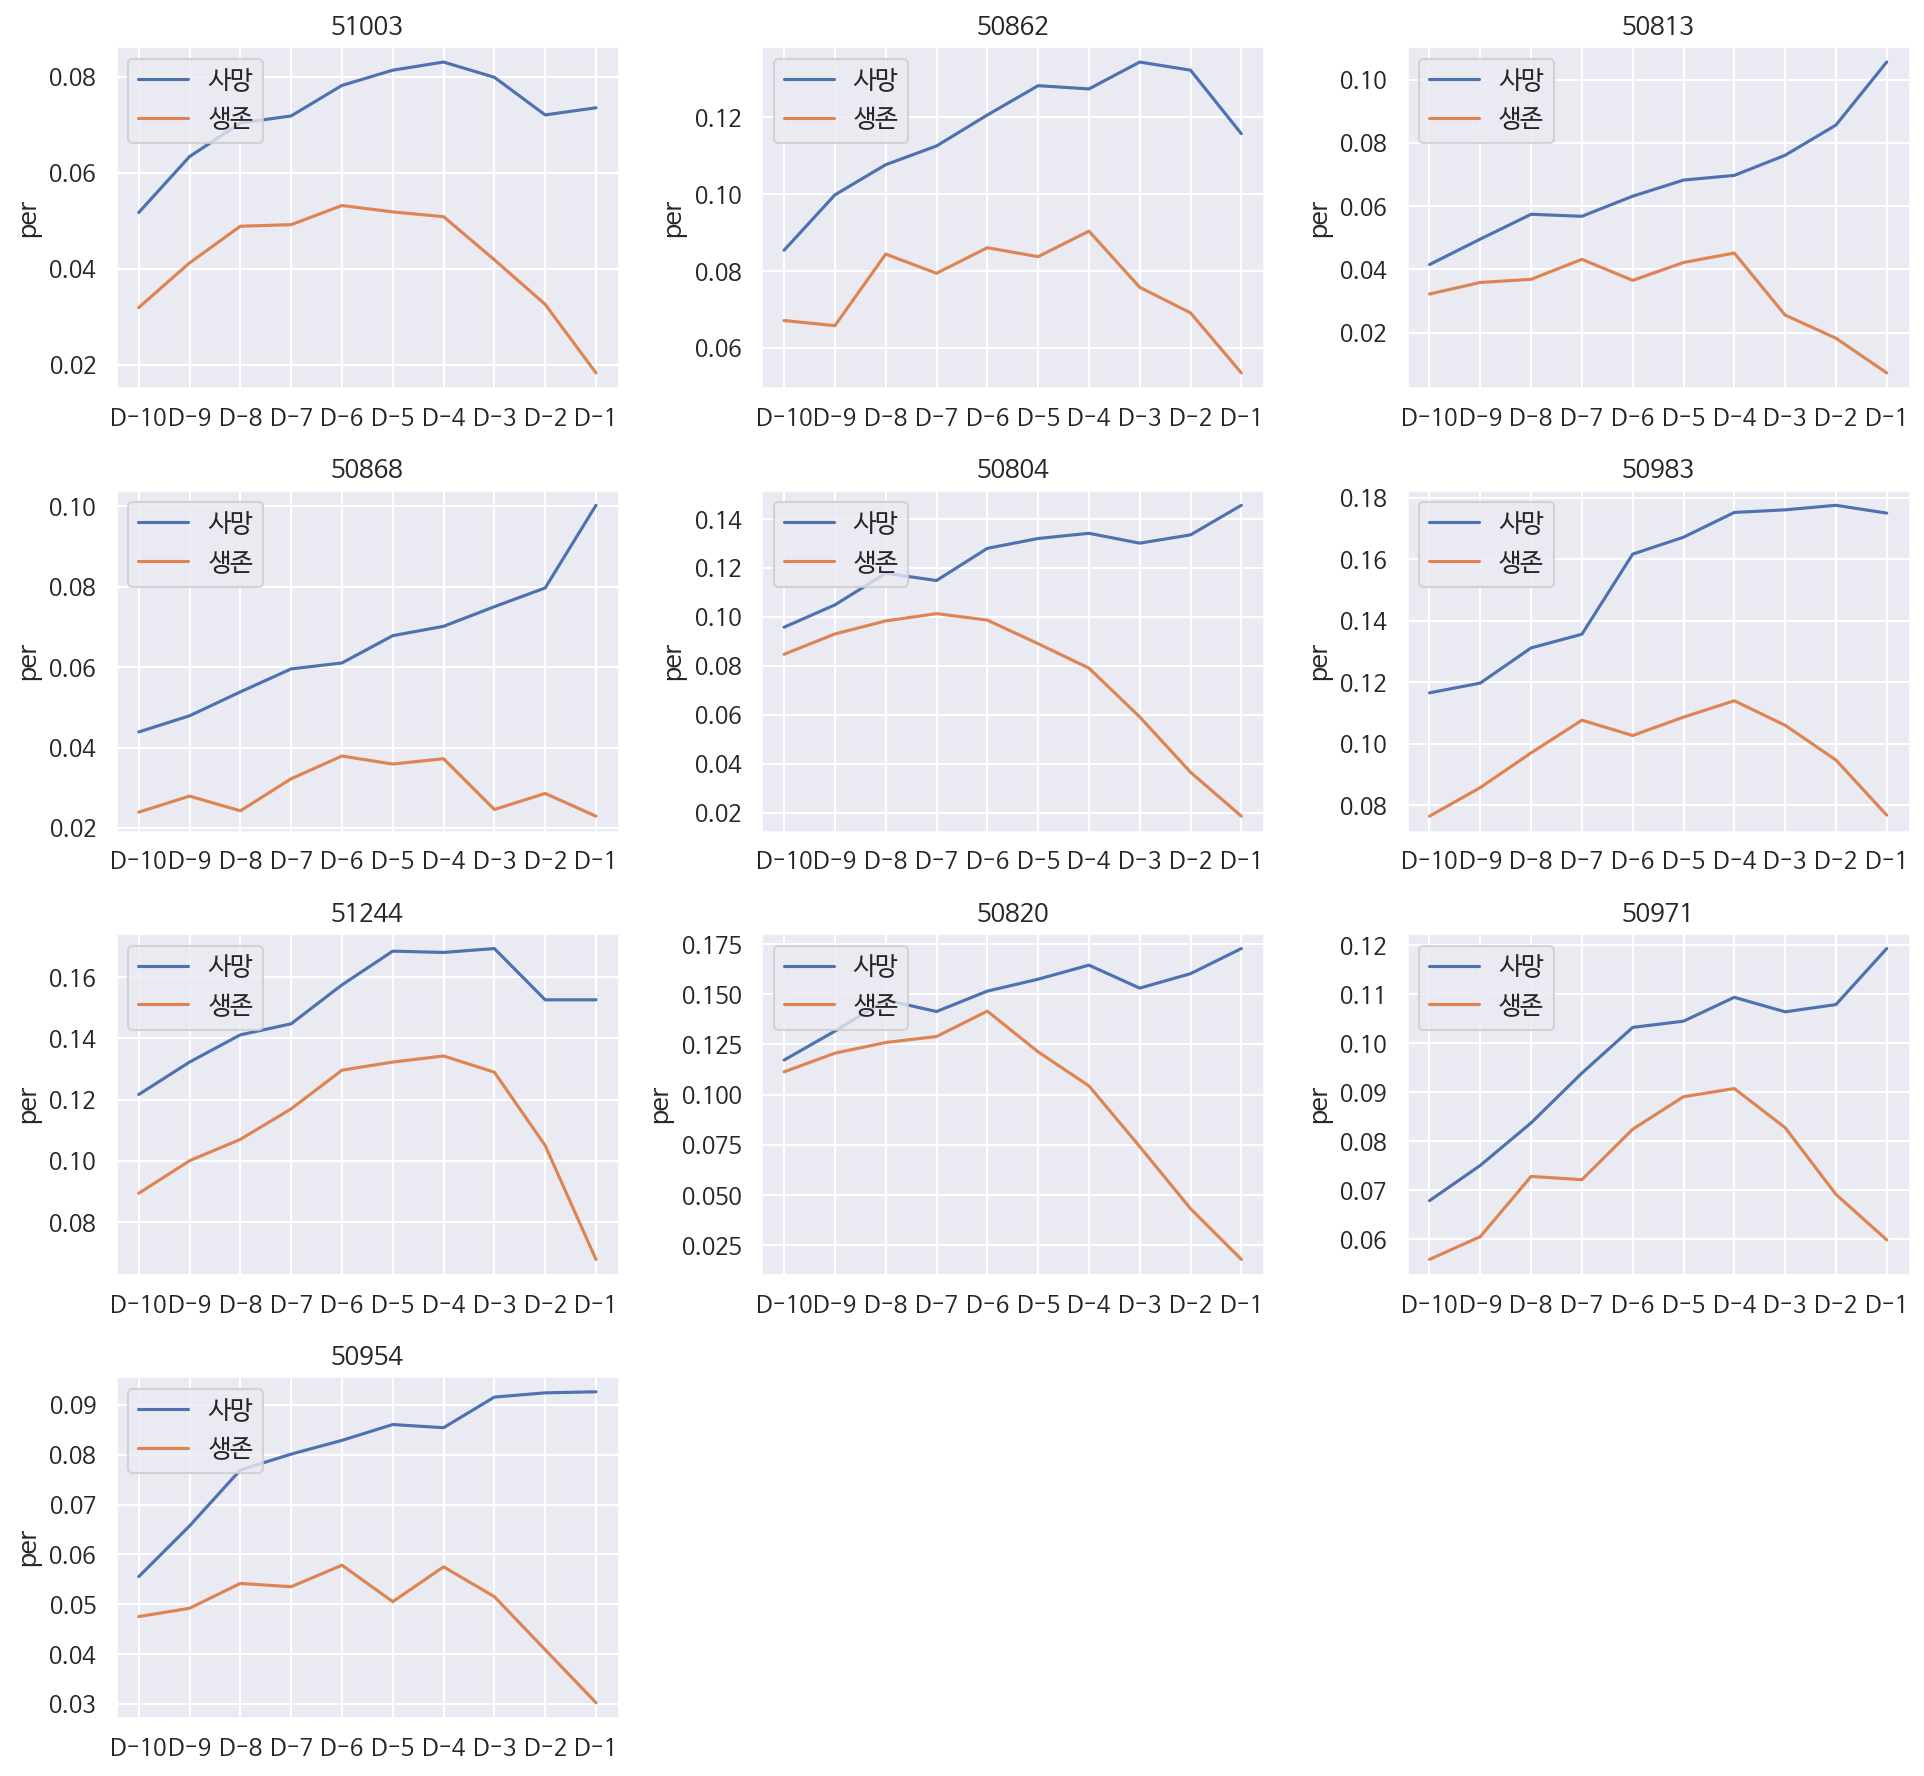

In [58]:
# 상위 10개 - 일관성 높은 사망 관련 feature
absum(LAB_list,LAB_list[:10])

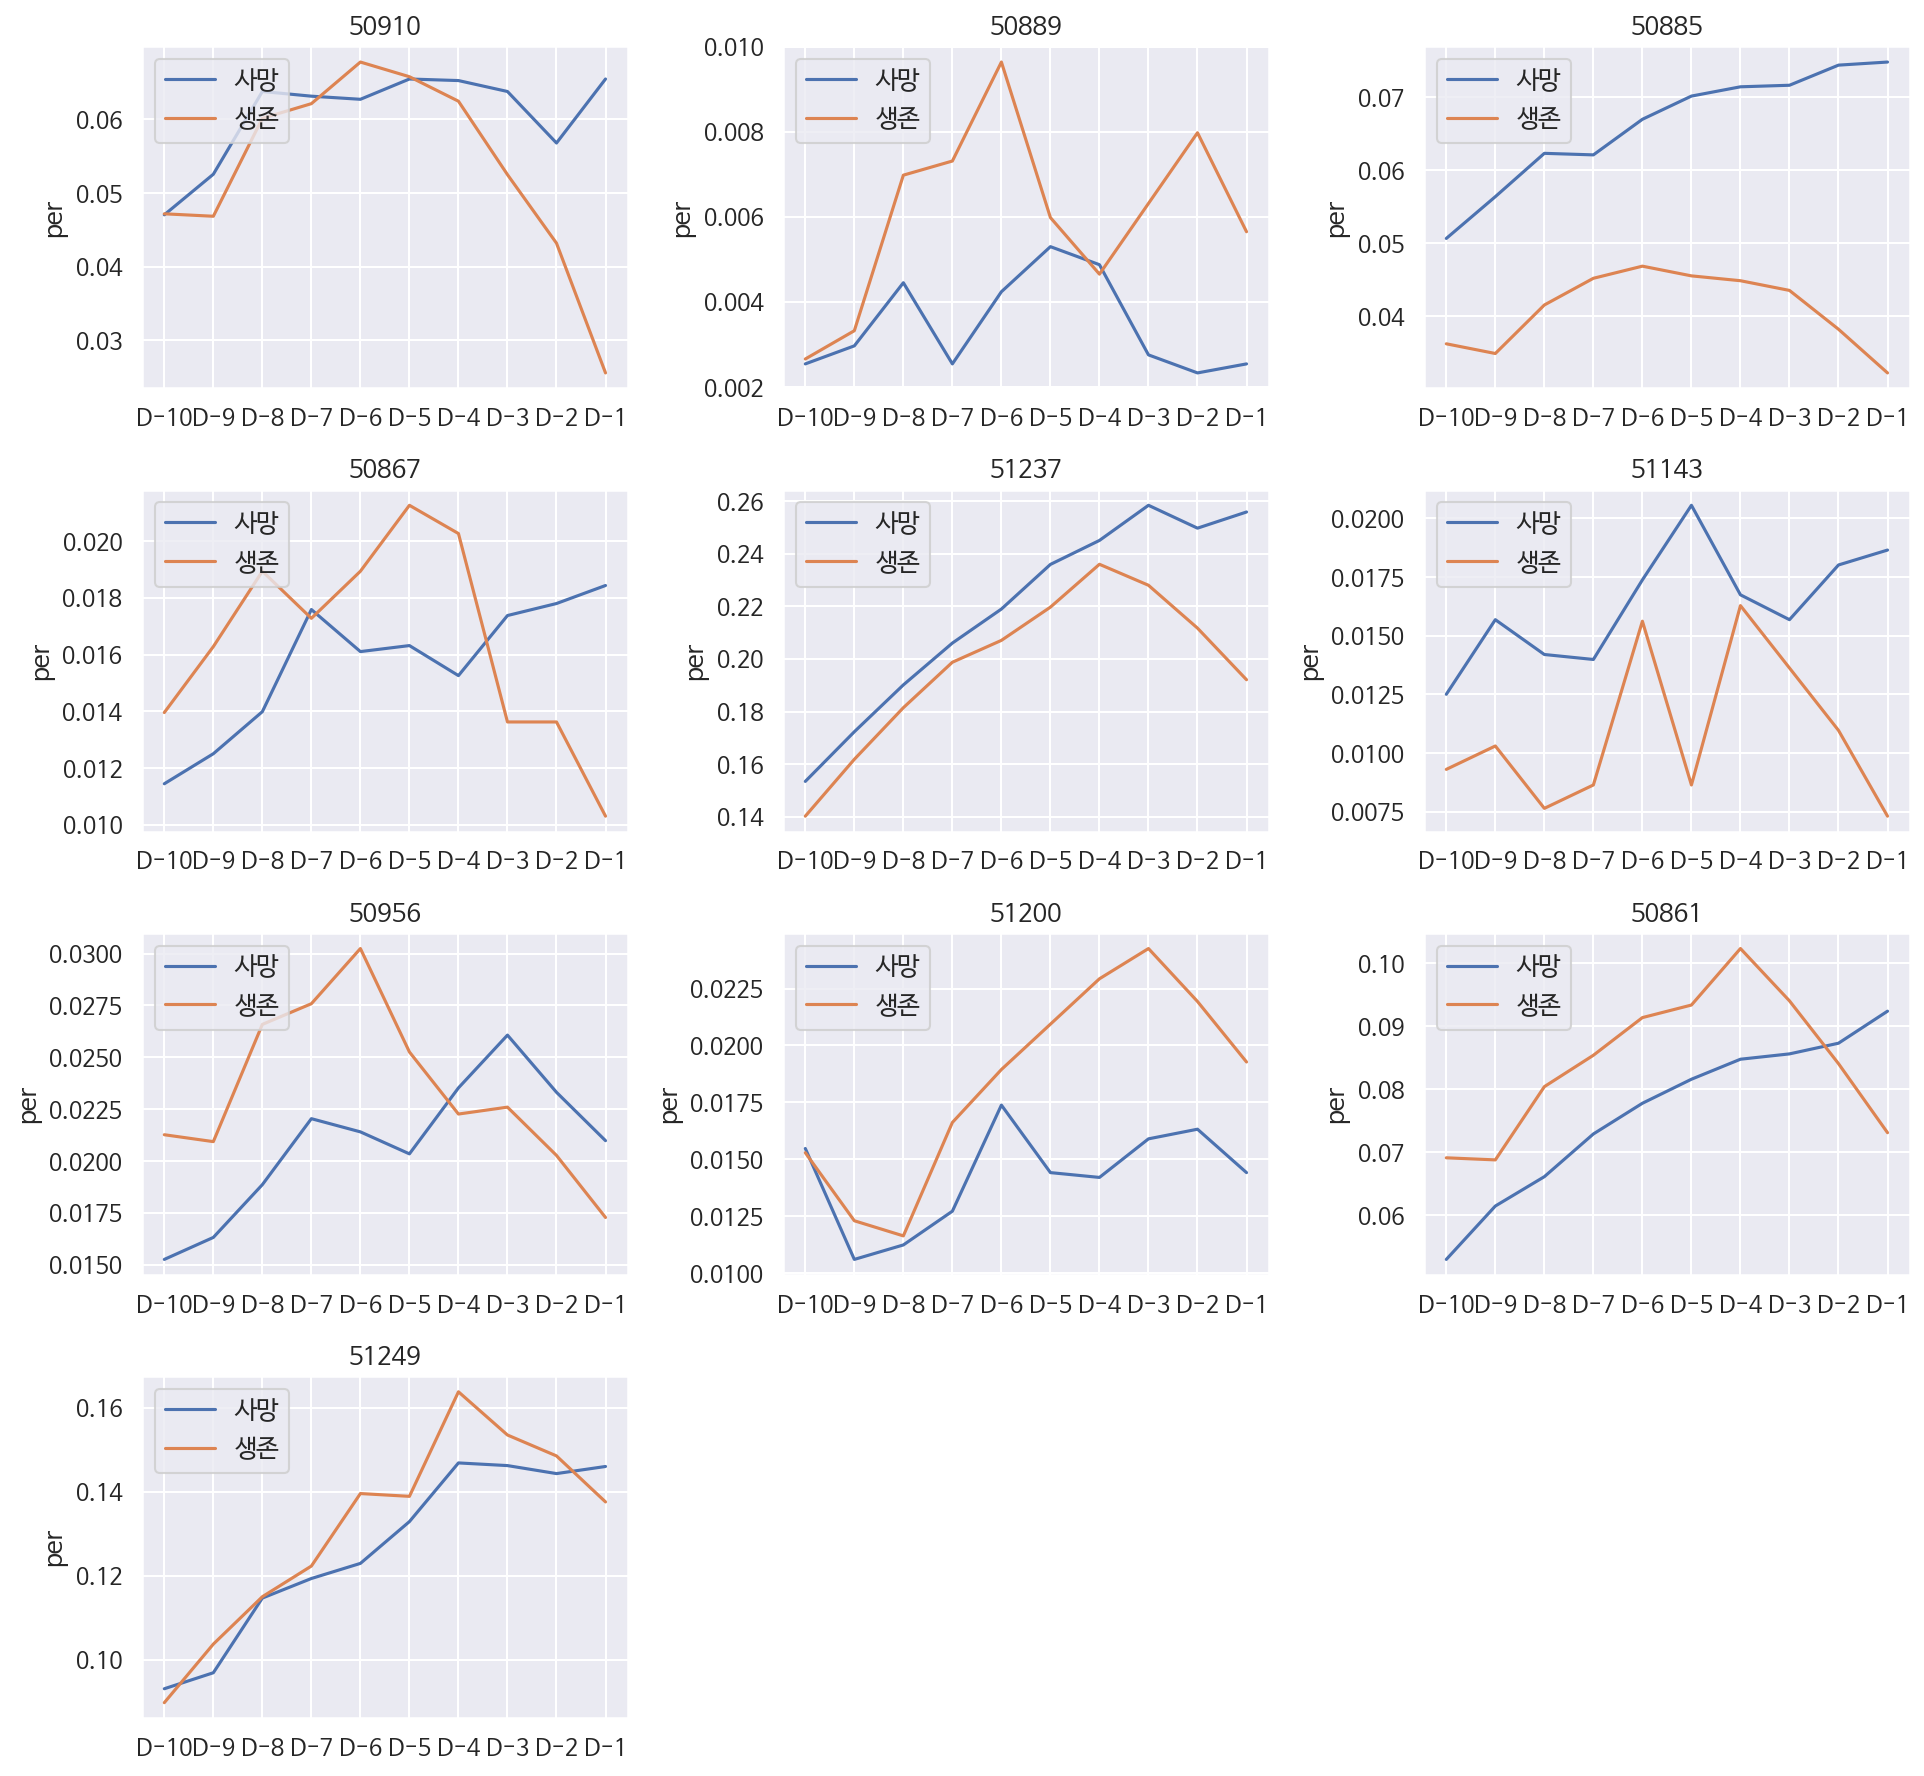

In [59]:
# 하위 10개 - 일관성 높은 생존 관련 feature
absum(LAB_list,LAB_list[-10:])